In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os
import math
import pickle
import datacube
import rioxarray
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar 

from IPython.display import Image
from datetime import datetime, timedelta

from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry

from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="Forest_fire_monitoring")

In [3]:
# Set important parameters for the analysis.

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

# Select an African country to carry out the analysis over.
country = "Tunisia"

# Select the fire event date.
fire_date = '2017-06-01'

# Length of baseline period / baseline composite image.
baseline_length = '3 months'

# Select the FIRMS MODIS hotspot data to load.
year = datetime.strptime(fire_date, "%Y-%m-%d").strftime("%Y")
fire_hotspots_fp = f"data/modis_{year}_{country.replace(' ', '_')}.geojson"

# Select the Land Use Land Cover Reclassification Geotiff to load. 
lulc_fp = f"{output_dir}/{year}_{country.replace(' ', '')}_reclassified_lulc.tif"

# Products to load.
products = ["ls8_sr"]

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
resolution = (-300, 300)

# Set the bands/measurements of the satellite data to load.
measurements = ['blue', 'green', 'red', 'nir', 'swir_1']

min_gooddata = 0.9

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
output_crs = "EPSG:6933"


# Parameters for the north arrow. 
x, y, arrow_length = 1.03, 0.5, 0.2

In [4]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

# List the countries in the African Countries GeoJSON.
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [5]:
# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
idx = african_countries[african_countries["COUNTRY"] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [6]:
# Calculate the start and end dates for the pre-fire/baseline and post-fire periods.
# Post-fire period is defined as 30 days after the "fire_date".

# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline period.
start_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))-timedelta(days=1)), '%Y-%m-%d')

# Calculate end date for post fire period.
start_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=1)), '%Y-%m-%d')
end_date_post = datetime.strftime(((datetime.strptime(fire_date, '%Y-%m-%d'))+timedelta(days=30)), '%Y-%m-%d')

# Print dates.
print('start_date_pre:  '+start_date_pre)
print('end_date_pre:    '+end_date_pre)
print('fire_date:       '+fire_date)
print('start_date_post: '+start_date_post)
print('end_date_post:   '+end_date_post)

start_date_pre:  2017-03-02
end_date_pre:    2017-05-31
fire_date:       2017-06-01
start_date_post: 2017-06-02
end_date_post:   2017-07-01


In [7]:
# Create a reusable datacube query object.
query = {"dc": dc,
         "products": products,
         "geopolygon": geom,
         "resolution": resolution,
         "output_crs": output_crs,
         "measurements": measurements,
         "min_gooddata": min_gooddata,
         "group_by":"solar_day"}

In [8]:
# Load data for the baseline period. 
baseline_ard = load_ard(time=(start_date_pre, start_date_post),
                         **query)


# Mask the baseline dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], baseline_ard)
baseline_ard = baseline_ard.where(mask)

print(baseline_ard)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step


/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 26 out of 29 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 26 time steps
<xarray.Dataset>
Dimensions:      (time: 26, y: 2522, x: 1311)
Coordinates:
  * time         (time) datetime64[ns] 2017-03-02T09:43:15.268761 ... 2017-06...
  * y            (y) float64 4.442e+06 4.441e+06 ... 3.686e+06 3.685e+06
  * x            (x) float64 7.262e+05 7.264e+05 ... 1.119e+06 1.119e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [9]:
# Generate the Normalized Difference Vegetation Index for the baseline period. 
baseline_ard = calculate_indices(baseline_ard,
                                 index=["NDVI"],
                                 satellite_mission="ls",
                                 drop=False)

# Generate the Normalized Burn Ratio Index for the baseline period.
baseline_ard["NBR"] = (baseline_ard.nir - baseline_ard.swir_1) / (baseline_ard.nir + baseline_ard.swir_1)

# Generate the Normalized Burn Ratio-Thermal Index for the baseline period.
baseline_ard["NBRT"] = (baseline_ard.nir - (baseline_ard.swir_1/1000)) / (baseline_ard.nir + (baseline_ard.swir_1/1000))

# Compute the median of the dataset along the time axis.
baseline_image = baseline_ard.median(dim='time')
# Export RGB image to GeoTIFF. 
write_cog(baseline_image[["blue", "green", "red"]].to_array(), fname=f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_RGB.tif", overwrite=True)

# Select the NDVI.
baseline_NDVI = baseline_image.NDVI
# Write to GeoTIFF. 
write_cog(baseline_NDVI, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_NDVI.tif", overwrite=True)

# Select the NBR.
baseline_NBR = baseline_image.NBR
# Write to GeoTIFF. 
write_cog(baseline_NBR, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_NBR.tif", overwrite=True)

# Select the NBRT.
baseline_NBRT = baseline_image.NBRT
# Write to GeoTIFF. 
write_cog(baseline_NBRT, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_NBRT.tif", overwrite=True)

PosixPath('results/tunisia_baseline_NBRT.tif')

In [10]:
# Load the data for the post-fire period. 
post_fire_ard = load_ard(time=(start_date_post, end_date_post),
                    **query)

# Mask the post-fire dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], post_fire_ard)
post_fire_ard = post_fire_ard.where(mask)

print(post_fire_ard)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 9 out of 10 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 9 time steps
<xarray.Dataset>
Dimensions:      (time: 9, y: 2522, x: 1311)
Coordinates:
  * time         (time) datetime64[ns] 2017-06-02T10:06:32.968717 ... 2017-06...
  * y            (y) float64 4.442e+06 4.441e+06 ... 3.686e+06 3.685e+06
  * x            (x) float64 7.262e+05 7.264e+05 ... 1.119e+06 1.119e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float32 nan nan nan nan n

In [11]:
# Generate the Normalized Difference Vegetation Index for the post-fire period. 
post_fire_ard = calculate_indices(post_fire_ard,
                                  index=["NDVI"],
                                  satellite_mission="ls",
                                  drop=False)

# Generate the Normalized Burn Ratio Index for the post-fire period.
post_fire_ard["NBR"] = (post_fire_ard.nir - post_fire_ard.swir_1) / (post_fire_ard.nir + post_fire_ard.swir_1)

# Generate the Normalized Burn Ratio-Thermal Index for the post-fire period.
post_fire_ard["NBRT"] = (post_fire_ard.nir - (post_fire_ard.swir_1/1000)) / (post_fire_ard.nir + (post_fire_ard.swir_1/1000))

# Select the post-fire image.

# Select the least cloudy image in the post-fire dataset 
# to use as the post-fire image by uncommenting the line below and changing the index.
#post_fire_image = post_fire_ard.isel(time=0)

# Compute the median of the dataset along the time axis.
post_fire_image = post_fire_ard.median(dim='time')
# Export RGB image to GeoTIFF. 
write_cog(post_fire_image[["blue", "green", "red"]].to_array(), fname=f"{output_dir}/{country.lower().replace(' ', '_')}_postfire_RGB.tif", overwrite=True)

# Select the NDVI.
post_fire_NDVI = post_fire_image.NDVI
# Write to GeoTIFF. 
write_cog(post_fire_NDVI, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_postfire_NDVI.tif", overwrite=True)

# Select the NBR.
post_fire_NBR = post_fire_image.NBR
# Write to GeoTIFF. 
write_cog(post_fire_NBR, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_postfire_NBR.tif", overwrite=True)

# Select the NBRT.
post_fire_NBRT = post_fire_image.NBRT
# Write to GeoTIFF. 
write_cog(post_fire_NBRT, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_postfire_NBRT.tif", overwrite=True)

PosixPath('results/tunisia_postfire_NBRT.tif')

In [12]:
# Calculate the Delta Indices. 
delta_NDVI = baseline_NDVI - post_fire_NDVI
# Write to GeoTIFF. 
write_cog(delta_NDVI, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_delta_NDVI.tif", overwrite=True)

delta_NBR = baseline_NBR - post_fire_NBR
# Write to GeoTIFF. 
write_cog(delta_NBR, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_delta_NBR.tif", overwrite=True)

delta_NBRT = baseline_NBRT - post_fire_NBRT
# Write to GeoTIFF. 
write_cog(delta_NBRT, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_delta_NBRT.tif", overwrite=True)

delta_NDVI_NBR = delta_NDVI - delta_NBR
# Write to GeoTIFF. 
write_cog(delta_NDVI_NBR, fname=f"{output_dir}/{country.lower().replace(' ', '_')}_delta_NDVI-delta_NBR.tif", overwrite=True)

PosixPath('results/tunisia_delta_NDVI-delta_NBR.tif')

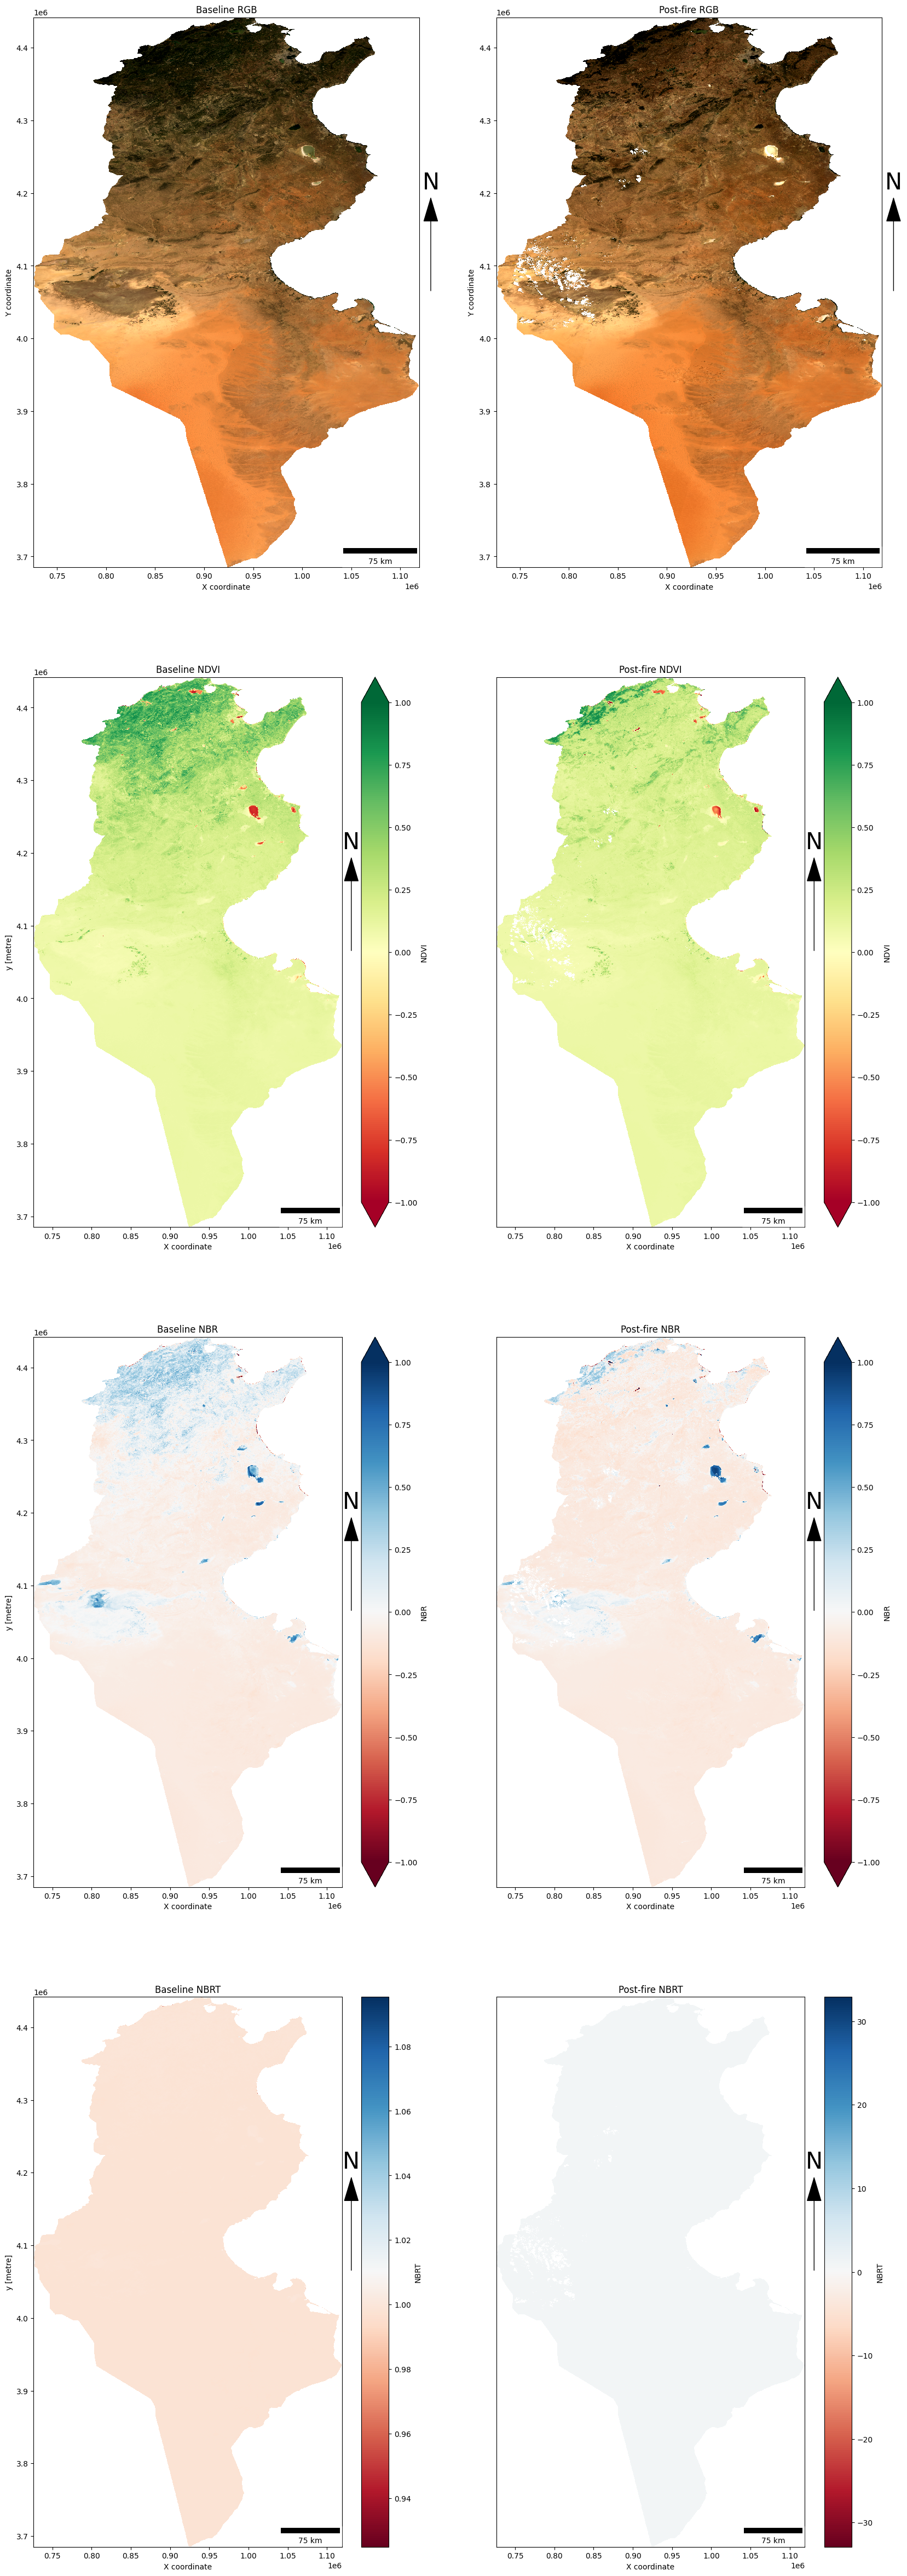

In [13]:
# Define the number of columns in the figure.
ncols = 2
# Define the number of rows in the figure.
nrows = 4
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualise the baseline true colour image.
rgb(baseline_image, bands=['red', 'green', 'blue'], ax=ax[0,0])
ax[0,0].set_title('Baseline RGB')
ax[0,0].set_xlabel('X coordinate')
ax[0,0].set_ylabel('Y coordinate')
ax[0,0].add_artist(ScaleBar(dx=1, location="lower right"))
ax[0,0].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[0,0].transAxes)

# Visualise the post-fire true color image.
rgb(post_fire_image, bands=['red', 'green', 'blue'], ax=ax[0,1])
ax[0,1].set_title('Post-fire RGB')
ax[0,1].set_xlabel('X coordinate')
ax[0,1].set_ylabel('Y coordinate')
ax[0,1].add_artist(ScaleBar(dx=1, location="lower right"))
ax[0,1].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[0,1].transAxes)

# Visualise the baseline NDVI image.
baseline_NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=ax[1,0])
ax[1,0].set_title('Baseline NDVI')
ax[1,0].yaxis.set_visible(True)
ax[1,0].set_xlabel('X coordinate')
ax[1,0].add_artist(ScaleBar(dx=1, location="lower right"))
ax[1,0].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[1,0].transAxes)

# Visualise the post-fire NDVI image.
post_fire_NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=ax[1,1])
ax[1,1].set_title('Post-fire NDVI')
ax[1,1].yaxis.set_visible(False)
ax[1,1].set_xlabel('X coordinate')
ax[1,1].add_artist(ScaleBar(dx=1, location="lower right"))
ax[1,1].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[1,1].transAxes)

# Visualise the baseline NBR imaage.
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax[2,0])
ax[2,0].set_title('Baseline NBR')
ax[2,0].yaxis.set_visible(True)
ax[2,0].set_xlabel('X coordinate')
ax[2,0].add_artist(ScaleBar(dx=1, location="lower right"))
ax[2,0].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[2,0].transAxes)

# Visualise the post-fire NBR image
post_fire_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax[2,1])
ax[2,1].set_title('Post-fire NBR')
ax[2,1].yaxis.set_visible(False)
ax[2,1].set_xlabel('X coordinate')
ax[2,1].add_artist(ScaleBar(dx=1, location="lower right"))
ax[2,1].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[2,1].transAxes)

# Visualise the baseline NBRT imaage.
baseline_NBRT.plot(cmap='RdBu', ax=ax[3,0])
ax[3,0].set_title('Baseline NBRT')
ax[3,0].yaxis.set_visible(True)
ax[3,0].set_xlabel('X coordinate')
ax[3,0].add_artist(ScaleBar(dx=1, location="lower right"))
ax[3,0].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[3, 0].transAxes)

# Visualise the post-fire NBRT image
post_fire_NBRT.plot(cmap='RdBu', ax=ax[3,1])
ax[3,1].set_title('Post-fire NBRT')
ax[3,1].yaxis.set_visible(False)
ax[3,1].set_xlabel('X coordinate')
ax[3,1].add_artist(ScaleBar(dx=1, location="lower right"))
ax[3,1].annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax[3,1].transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_pre_and_post_fire_rgb_ndvi_nbr_nbrt.png")
plt.show()

In [14]:
# Examine the hotposts using FIRMS Active Fire/Hotspot data. 

# Read the GeoJSON file as a geopandas GeoDataFrame.
fire_hotspots = gpd.read_file(fire_hotspots_fp)

# Select the fire_hotspots data for the post-fire period.
fire_hotspots["acq_date"] = pd.to_datetime(fire_hotspots["acq_date"])
mask = (fire_hotspots["acq_date"] >= start_date_post) & (fire_hotspots["acq_date"] <= end_date_post)
fire_hotspots = fire_hotspots.loc[mask]

# Extract the location of hotspots from the GeoDataFrame into a numpy.ndarray
spot_locs = fire_hotspots.to_crs(output_crs)
spot_locs = np.array([[item.x, item.y] for item in spot_locs.geometry.to_list()])

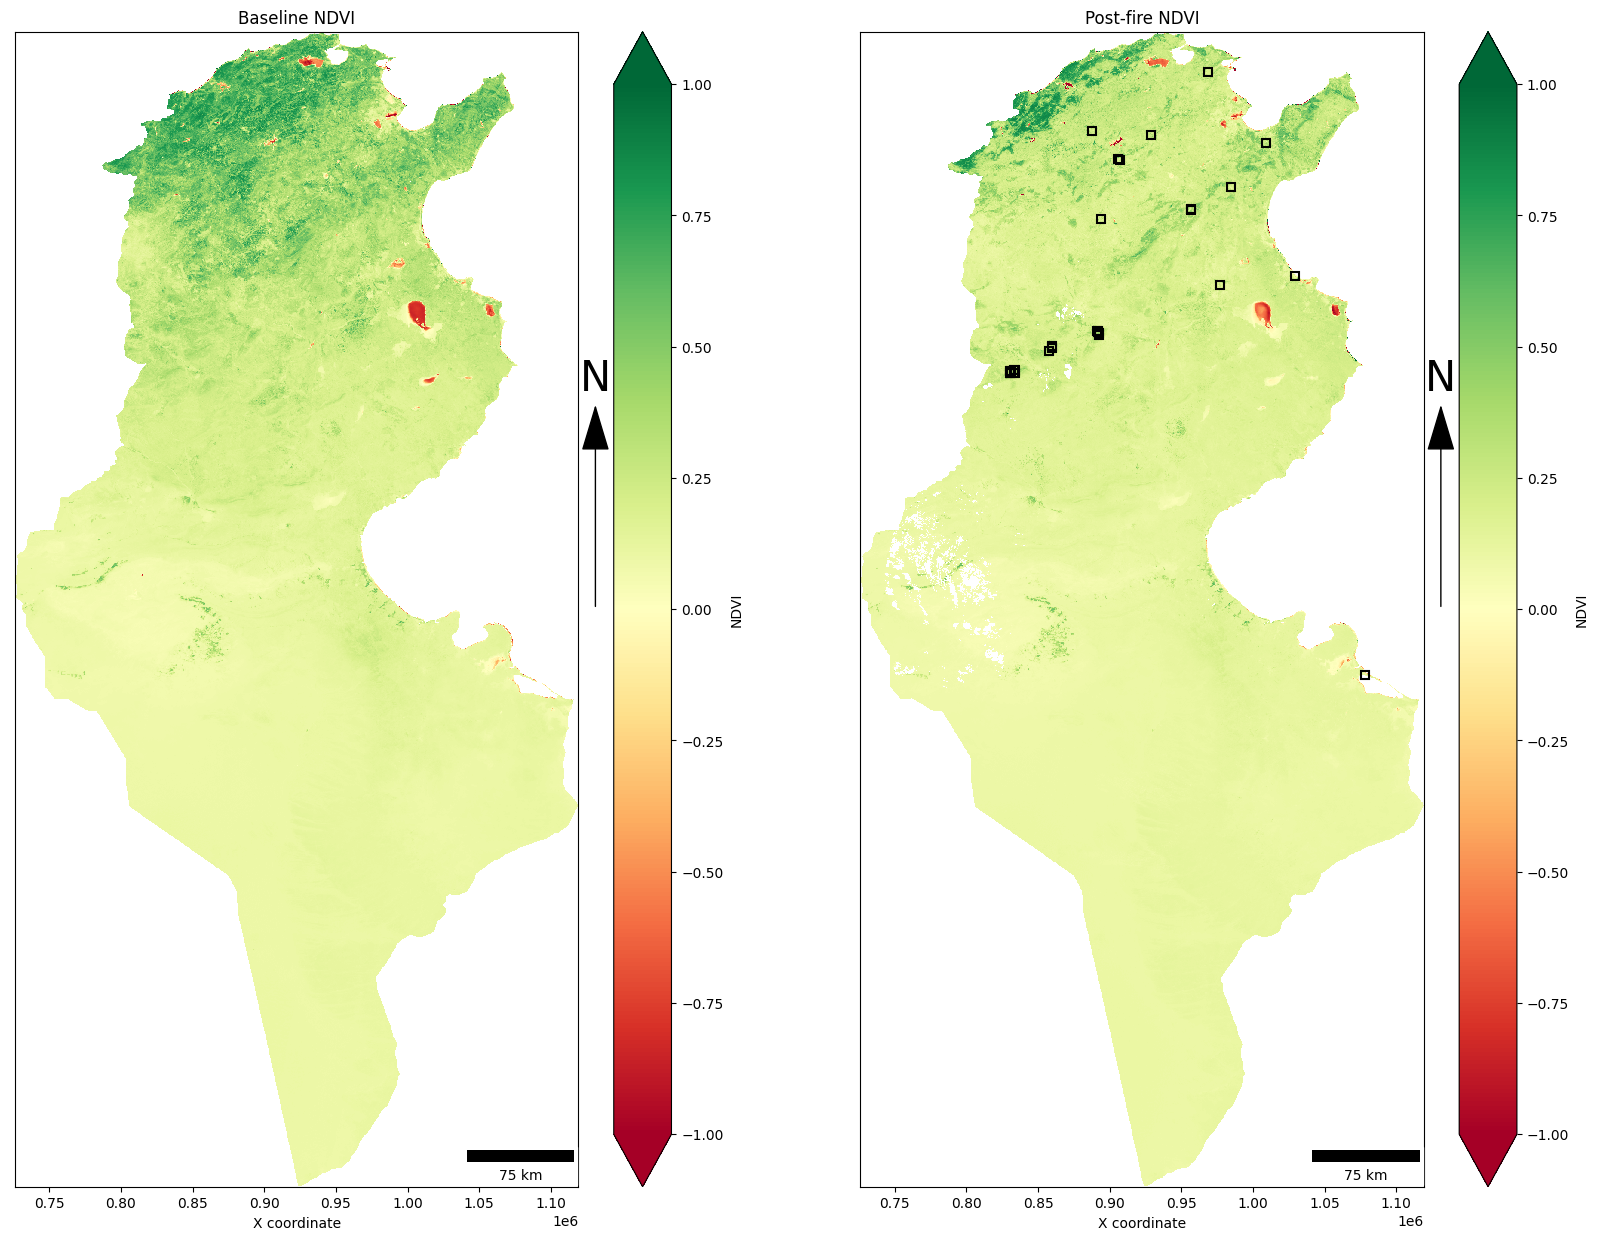

In [15]:
# Plot the FIRMS hotspots on top of the post-fire NDVI image. 

# Define the number of columns in the figure.
ncols = 2
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualise the baseline NDVI image.
baseline_NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Baseline NDVI')
ax1.yaxis.set_visible(False)
ax1.set_xlabel('X coordinate')
ax1.add_artist(ScaleBar(dx=1, location="lower right"))
ax1.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax1.transAxes)

# Visualise the post-fire NDVI image and the hotspots.
post_fire_NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=ax2)
ax2.plot(spot_locs[:,0], spot_locs[:,1], marker='s',
       linestyle='', mfc='None', mec='k', mew=1.5)
ax2.set_title('Post-fire NDVI')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')
ax2.add_artist(ScaleBar(dx=1, location="lower right"))
ax2.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax2.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_and_postfire_NDVI.png")

plt.show()

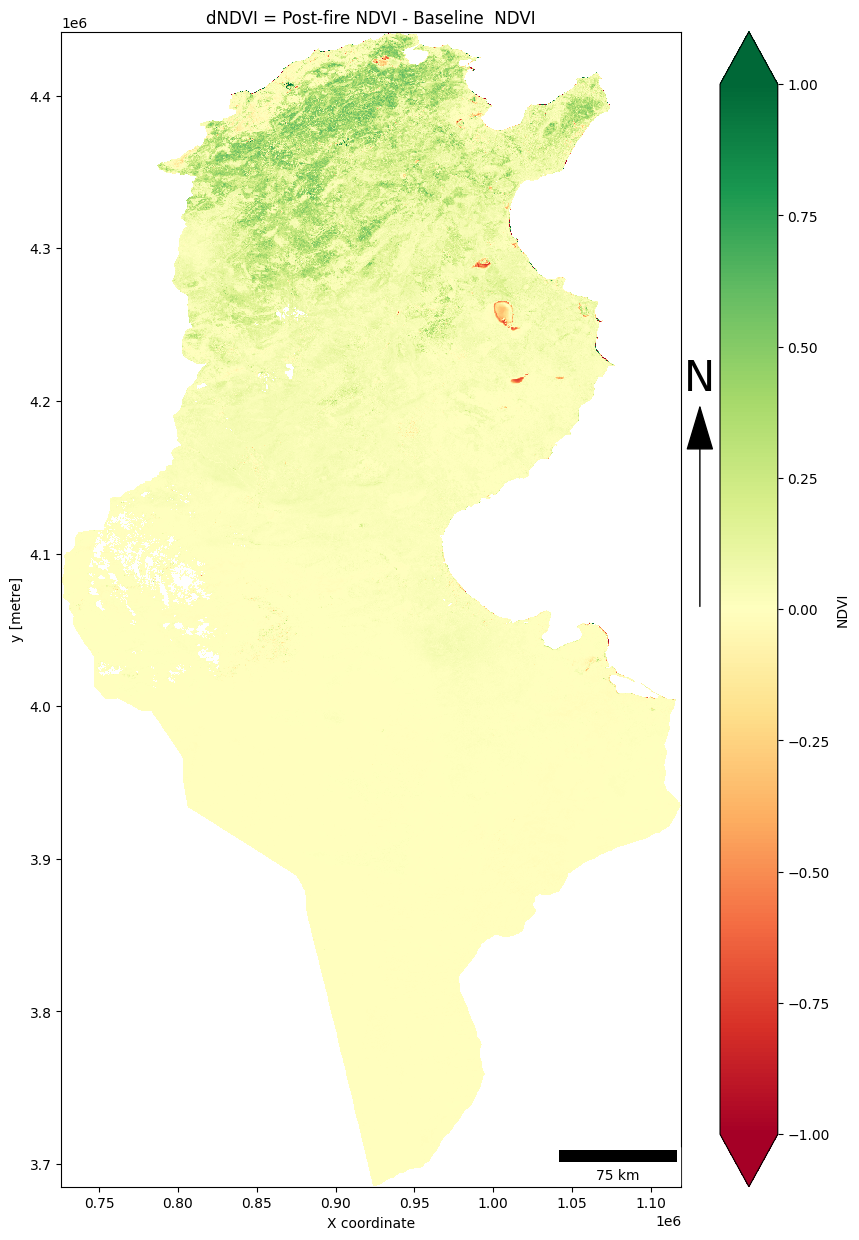

In [16]:
# Define the number of columns in the figure.
ncols = 1
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualize the difference between the post-fire and baseline NDVI.
delta_NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=ax)
ax.set_title('dNDVI = Post-fire NDVI - Baseline  NDVI')
ax.yaxis.set_visible(True)
ax.set_xlabel('X coordinate')
ax.add_artist(ScaleBar(dx=1, location="lower right"))
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_dNDVI.png")

plt.show()

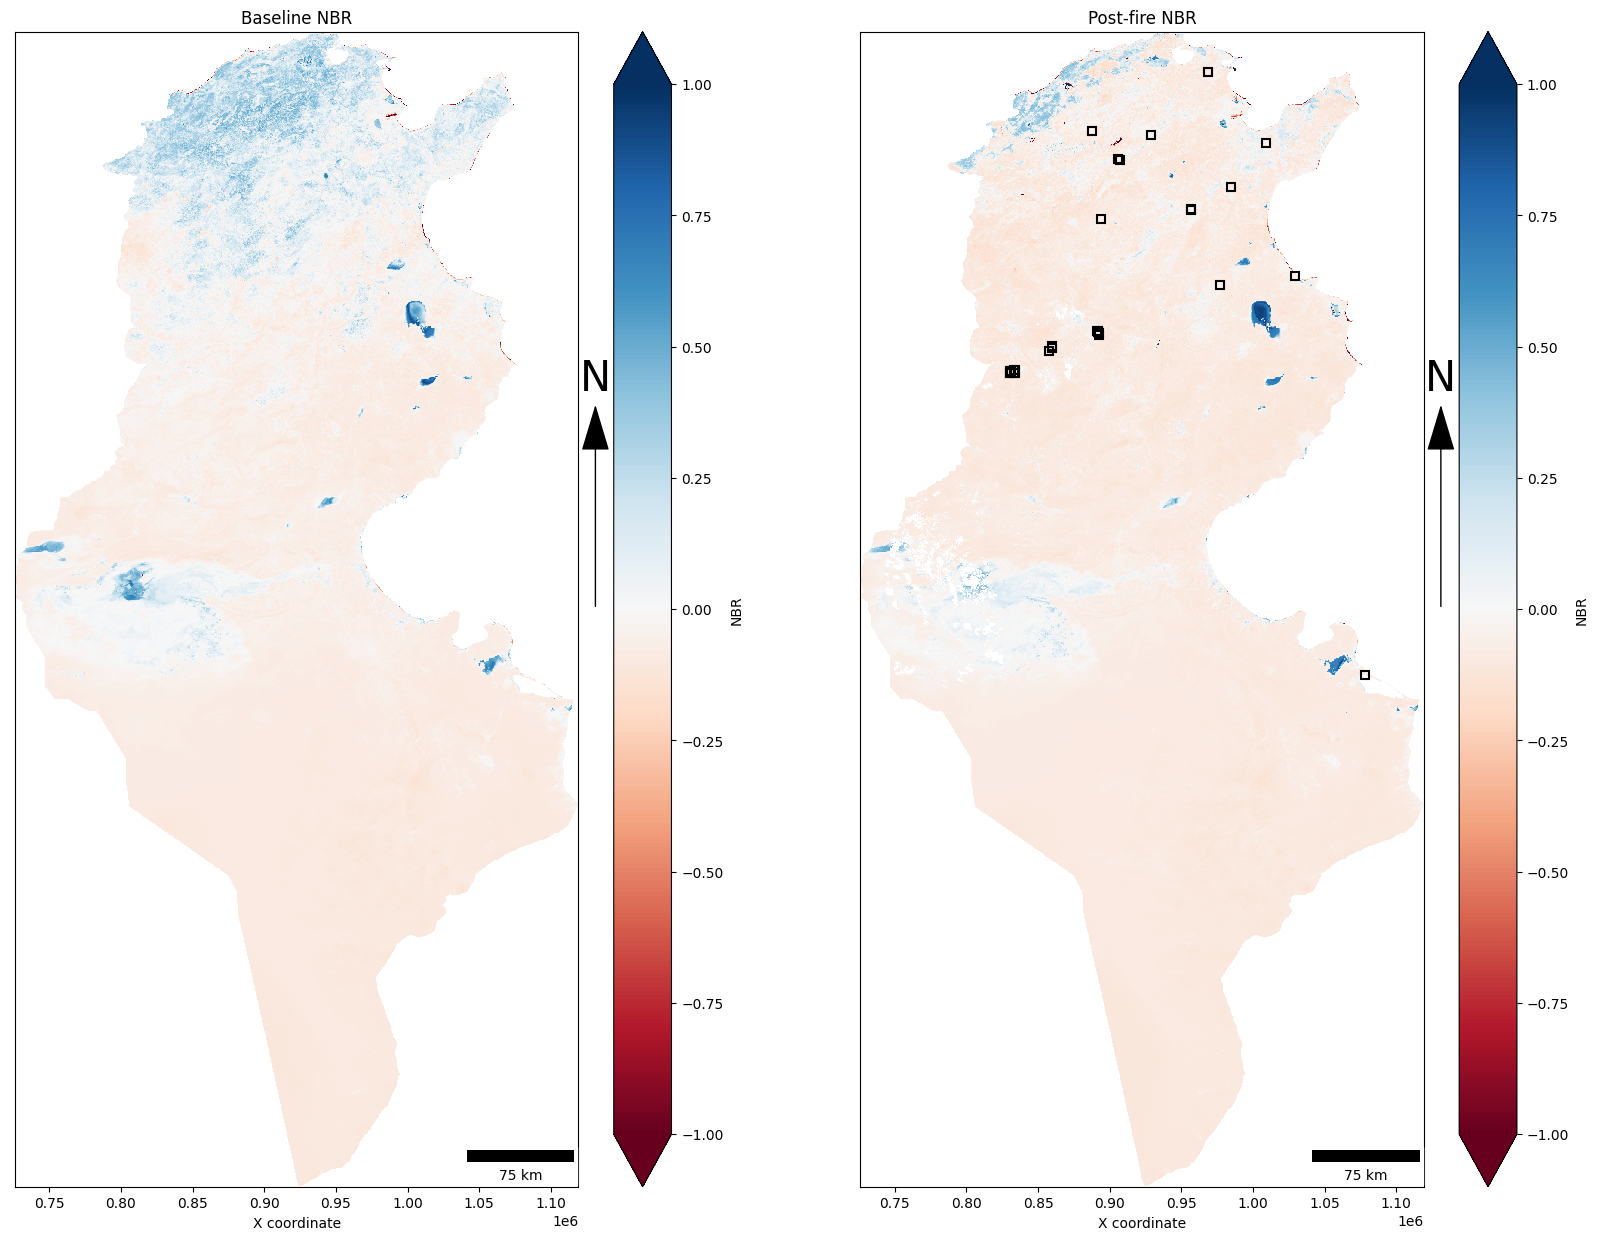

In [17]:
# Plot the FIRMS hotspots on top of the post-fire NBR image. 

# Define the number of columns in the figure.
ncols = 2
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualise the baseline NBR image.
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax1)
ax1.set_title('Baseline NBR')
ax1.yaxis.set_visible(False)
ax1.set_xlabel('X coordinate')
ax1.add_artist(ScaleBar(dx=1, location="lower right"))
ax1.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax1.transAxes)

# Visualise post-fire NBR image and the hotspots.
post_fire_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax2)
ax2.plot(spot_locs[:,0], spot_locs[:,1], marker='s',
       linestyle='', mfc='None', mec='k', mew=1.5)
ax2.set_title('Post-fire NBR')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')
ax2.add_artist(ScaleBar(dx=1, location="lower right"))
ax2.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax2.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_and_postfire_NBR.png")

plt.show()

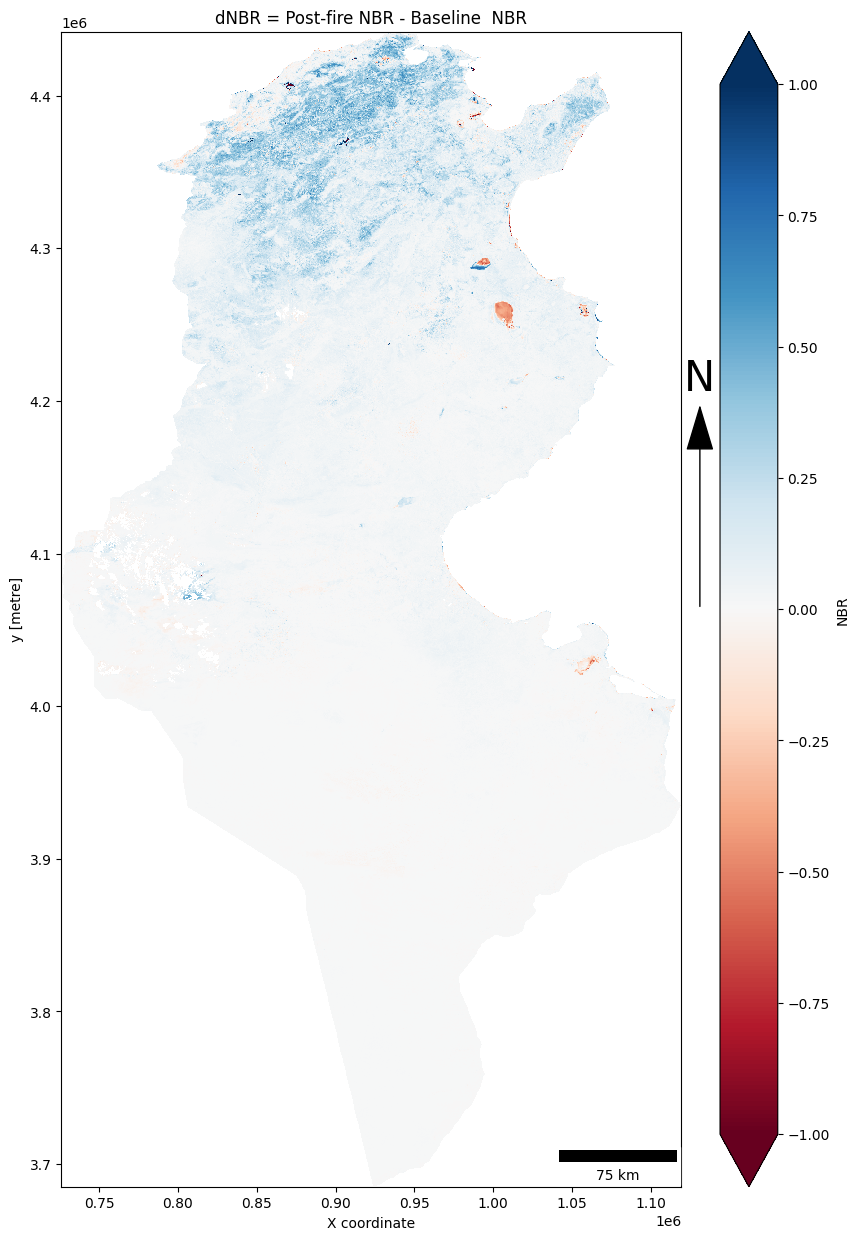

In [18]:
# Define the number of columns in the figure.
ncols = 1
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualize the difference between the post-fire and baseline NBR.
delta_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=ax)
ax.set_title('dNBR = Post-fire NBR - Baseline  NBR')
ax.yaxis.set_visible(True)
ax.set_xlabel('X coordinate')
ax.add_artist(ScaleBar(dx=1, location="lower right"))
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_dNBR.png")

plt.show()

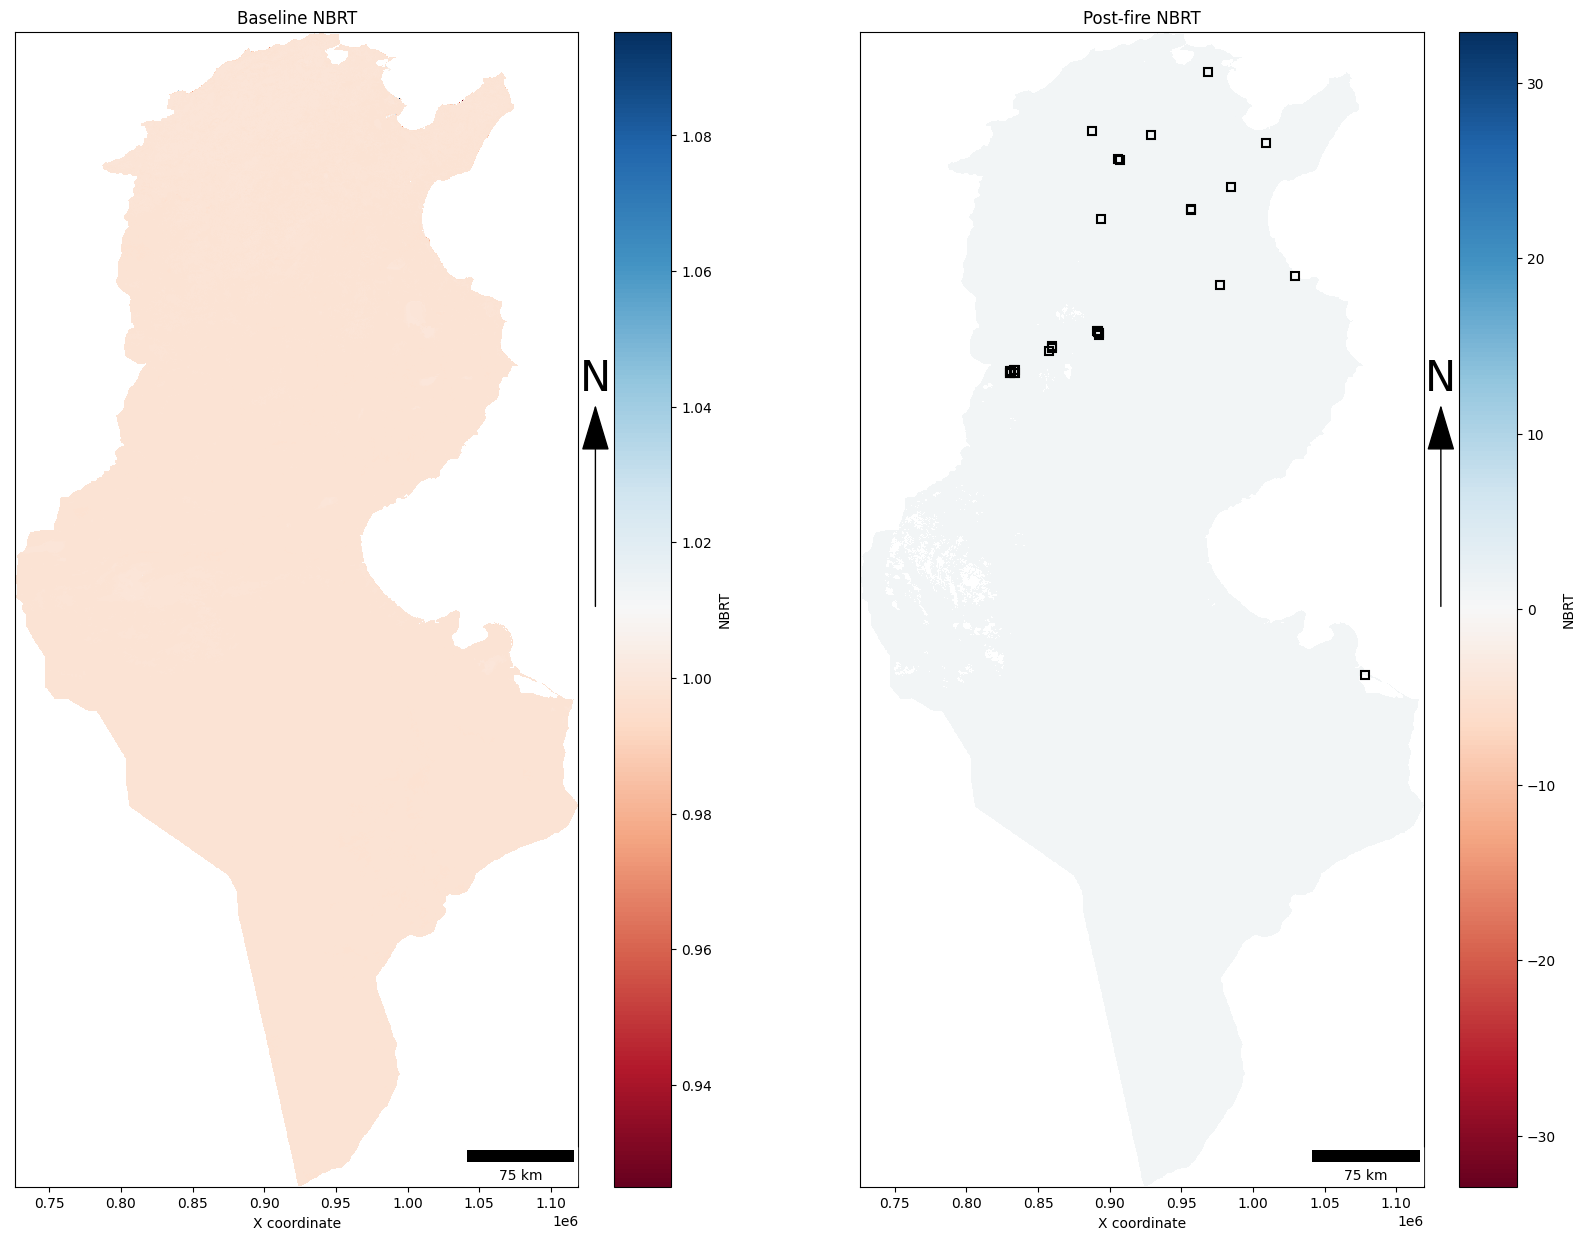

In [19]:
# Plot the FIRMS hotspots on top of the post-fire NBRT image. 

# Define the number of columns in the figure.
ncols = 2
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
f, (ax1, ax2) = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualise the baseline NBRT image.
baseline_NBRT.plot(cmap='RdBu', ax=ax1)
ax1.set_title('Baseline NBRT')
ax1.yaxis.set_visible(False)
ax1.set_xlabel('X coordinate')
ax1.add_artist(ScaleBar(dx=1, location="lower right"))
ax1.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax1.transAxes)

# Visualise post-fire NBRT image and the hotspots.
post_fire_NBRT.plot(cmap='RdBu', ax=ax2)
ax2.plot(spot_locs[:,0], spot_locs[:,1], marker='s',
       linestyle='', mfc='None', mec='k', mew=1.5)
ax2.set_title('Post-fire NBRT')
ax2.yaxis.set_visible(False)
ax2.set_xlabel('X coordinate')
ax2.add_artist(ScaleBar(dx=1, location="lower right"))
ax2.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax2.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_baseline_and_postfire_NBRT.png")

plt.show()

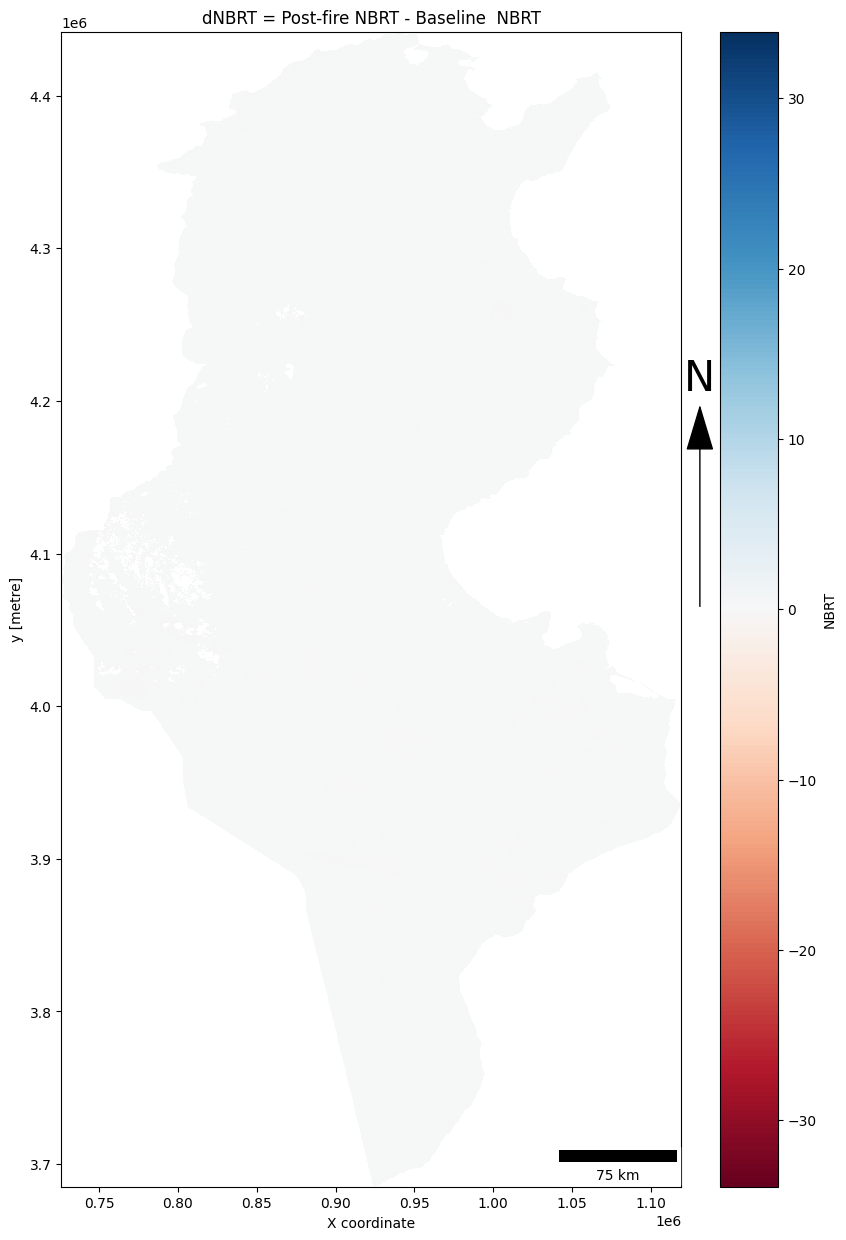

In [20]:
# Define the number of columns in the figure.
ncols = 1
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualize the difference between the post-fire and baseline NBRT.
delta_NBRT.plot(cmap='RdBu', ax=ax)
ax.set_title('dNBRT = Post-fire NBRT - Baseline  NBRT')
ax.yaxis.set_visible(True)
ax.set_xlabel('X coordinate')
ax.add_artist(ScaleBar(dx=1, location="lower right"))
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_dNBRT.png")

plt.show()

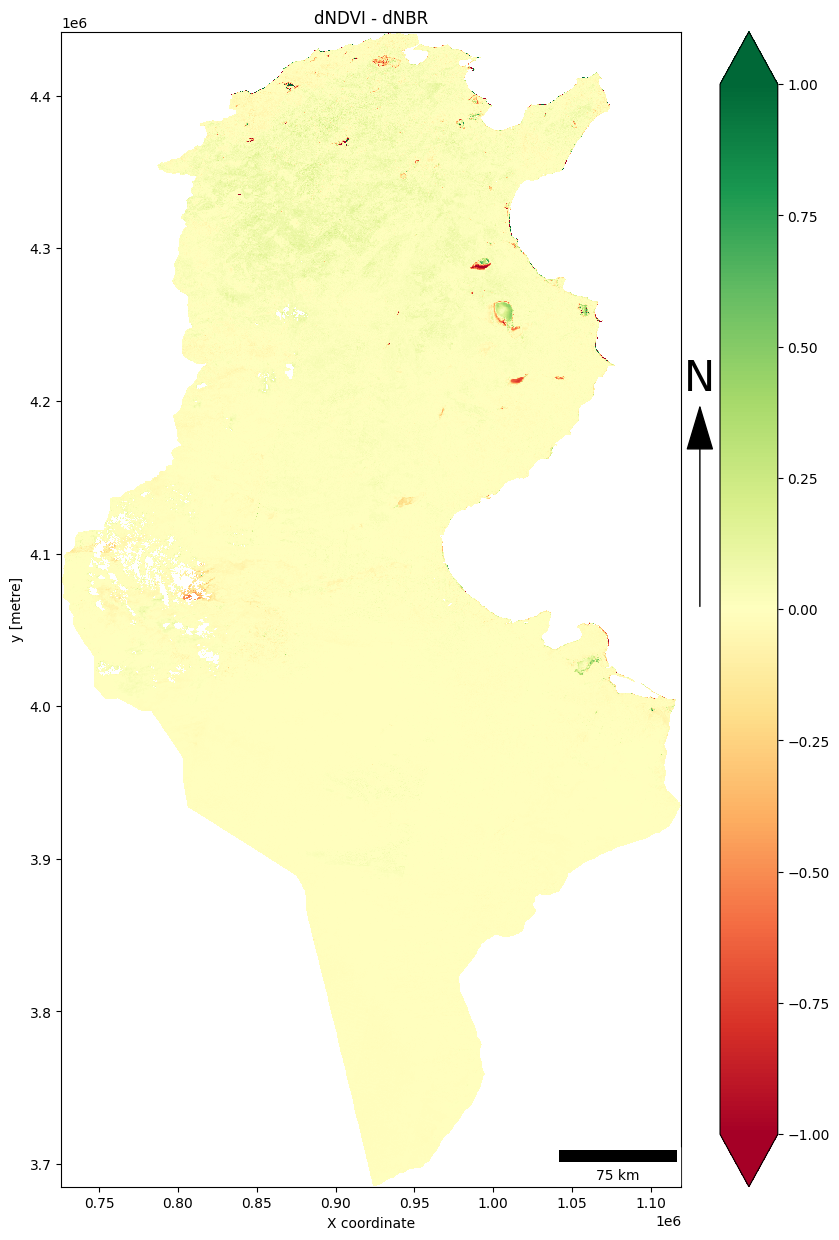

In [21]:
# Define the number of columns in the figure.
ncols = 1
# Define the number of rows in the figure.
nrows = 1
# For a single subplot width=10 and length=15. 
figure_width = 10 * ncols 
figure_length = 15 * nrows

# Set up subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figure_width, figure_length))

# Visualize the difference between dNBR and dNDVI.
delta_NDVI_NBR.plot(cmap='RdYlGn', vmin=-1, vmax=1, ax=ax)
ax.set_title('dNDVI - dNBR')
ax.yaxis.set_visible(True)
ax.set_xlabel('X coordinate')
ax.add_artist(ScaleBar(dx=1, location="lower right"))
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                 arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.3', facecolor='black'),
                 ha='center', va='center', fontsize=30,
                 xycoords=ax.transAxes)

plt.savefig(f"{output_dir}/{country.lower().replace(' ', '_')}_dNDVI-dNBR.png")

plt.show()

In [22]:
# Extract NBR values at the hotspot locations to determine 
# how fire has influenced the NBR values. 

point_nbr = {}

# Extract baseline NBR values at the hotspot locations.
point_nbr["baseline"] = np.diagonal(baseline_NBR.sel(x=spot_locs[:,0],
                                                     y=spot_locs[:,1],
                                                     method='nearest'))


# Extract post-fire NBR values at the hotspot locations.
point_nbr["post"] = np.diagonal(post_fire_NBR.sel(x=spot_locs[:,0],
                                                  y=spot_locs[:,1],
                                                  method='nearest'))

In [23]:
# Extract NDVI values at the hotspot locations to determine 
# how fire has influenced the NDVI values. 

point_ndvi = {}

# Extract baseline NDVI values at the hotspot locations.
point_ndvi["baseline"] = np.diagonal(baseline_NDVI.sel(x=spot_locs[:,0],
                                                     y=spot_locs[:,1],
                                                     method='nearest'))


# Extract post-fire NDVI values at the hotspot locations.
point_ndvi["post"] = np.diagonal(post_fire_NDVI.sel(x=spot_locs[:,0],
                                                  y=spot_locs[:,1],
                                                  method='nearest'))

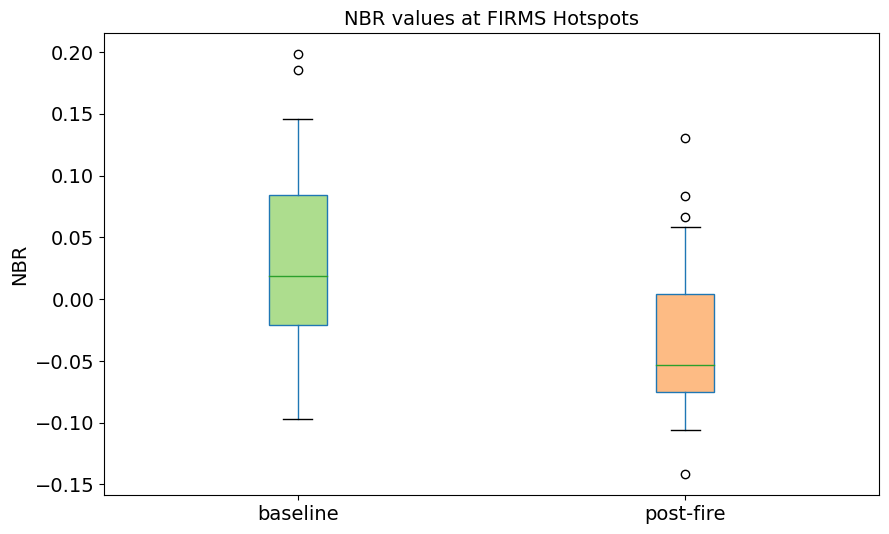

In [24]:
# Using the extracted NBR values make a box plot of the baseline and post-fire NBR values for the hotspot locations. 

ax = pd.DataFrame(point_nbr).boxplot(figsize=(10, 6), 
                                     whis=0.75,
                                     patch_artist=True,
                                     vert=True, 
                                     fontsize=14,
                                     return_type='both')


ax[0].set_ylabel("NBR", fontsize=14)
ax[0].set_title("NBR values at FIRMS Hotspots", fontsize=14);
ax[0].set_xticklabels(["baseline", "post-fire"])
ax[0].grid(False)

colors = ['#addd8e', '#fdbb84']

for patch, color in zip(ax[1]['boxes'], colors):
    patch.set_facecolor(color)
    
    
# Here, we can notice that the post-fire NBR values decrease from the baseline 
# NBR at the hotspots, consistent with those locations having been affected by the fire.

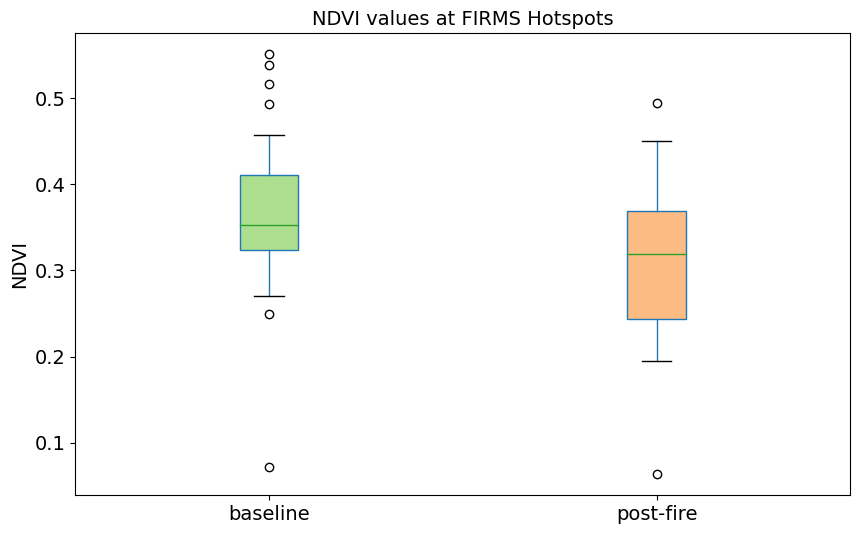

In [25]:
# Using the extracted NDVI values, make a box plot of the baseline and post-fire NDVI values for the hotspot locations. 

ax = pd.DataFrame(point_ndvi).boxplot(figsize=(10, 6), 
                                      whis=0.75,
                                      patch_artist=True,
                                      vert=True, 
                                      fontsize=14,
                                      return_type='both')


ax[0].set_ylabel("NDVI", fontsize=14)
ax[0].set_title("NDVI values at FIRMS Hotspots", fontsize=14);
ax[0].set_xticklabels(["baseline", "post-fire"])
ax[0].grid(False)

colors = ['#addd8e', '#fdbb84']

for patch, color in zip(ax[1]['boxes'], colors):
    patch.set_facecolor(color)
    
    
# Here, we can notice that the post-fire NDVI values decrease from the baseline 
# NDVI at the hotspots, consistent with those locations having been affected by the fire.

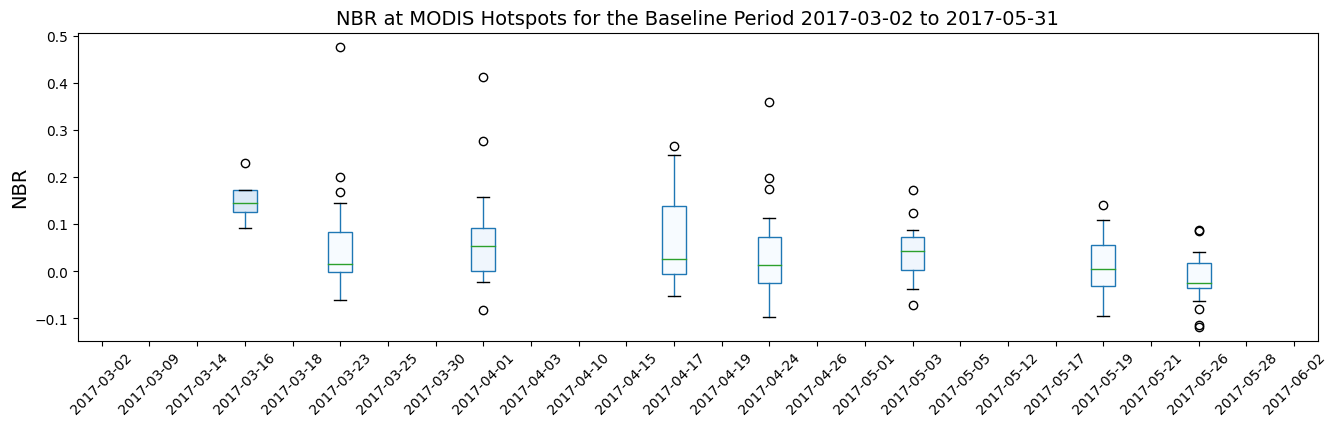

In [26]:
# Compare the change in NBR over the course of the baselilne period at the hotspots.

# Get cleaned baseline dataset observation dates.
baseline_ard['time'] = baseline_ard.indexes['time'].normalize()
dates = (pd.to_datetime((baseline_ard.time).values)).strftime('%Y-%m-%d')

# Get the baseline NBR values  at all hotpots for 
# each time step in the baseline dataset. 
baseline_nbr_spot = baseline_ard.NBR.sel(x=spot_locs[:,0],
                                         y=spot_locs[:,1],
                                         method='nearest')

nbr_over_time = {}
for i in range(len(dates)):
    nbr_over_time[dates[i]] = np.diagonal(baseline_nbr_spot[i,:,:])
nbr_over_time = pd.DataFrame(nbr_over_time)

# Create a box plot for each observation / time step.
ax = nbr_over_time.boxplot(figsize=(16, 4), 
                           whis=0.75,
                           patch_artist=True,
                           vert=True, 
                           return_type='both')

ax[0].set_ylabel("NBR", fontsize=14)
ax[0].set_title(f"NBR at MODIS Hotspots for the Baseline Period {start_date_pre} to {end_date_pre}", fontsize=14);
ax[0].grid(False)


# Colour the boxes by the mean NBR of each observation
cm = plt.cm.get_cmap("Blues", len(nbr_over_time.index))
colors = [cm(item.get_ydata().mean()) for item in ax[1]['medians']]
for patch, color in zip(ax[1]['boxes'], colors):
    patch.set_facecolor(color)
ax[0].tick_params(axis='x', rotation=45)

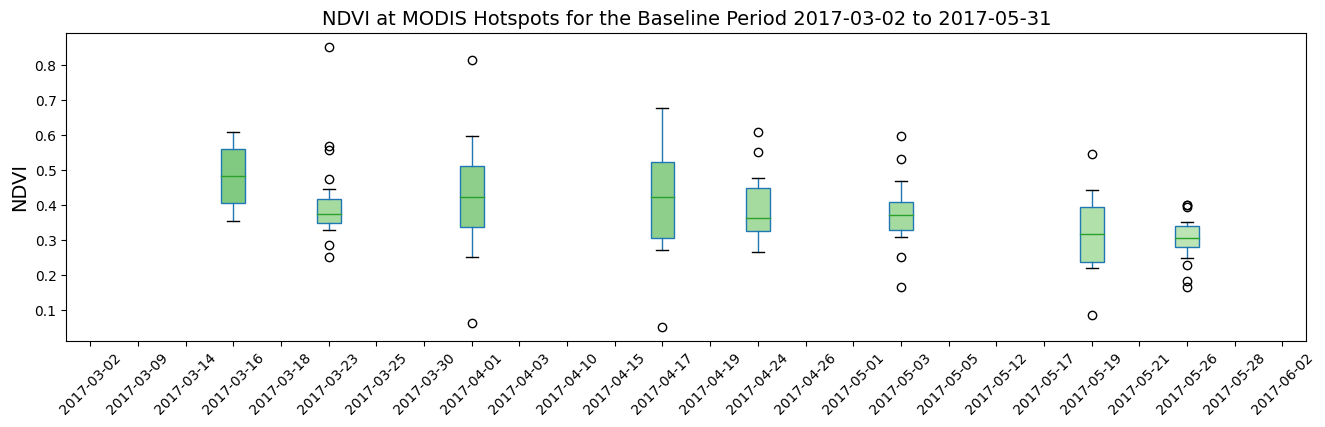

In [27]:
# Compare the change in NDVI over the course of the baselilne period at the hotspots.

# Get the baseline NDVI values  at all hotpots for 
# each time step in the baseline dataset. 
baseline_ndvi_spot = baseline_ard.NDVI.sel(x=spot_locs[:,0],
                                         y=spot_locs[:,1],
                                         method='nearest')

ndvi_over_time = {}
for i in range(len(dates)):
    ndvi_over_time[dates[i]] = np.diagonal(baseline_ndvi_spot[i,:,:])
ndvi_over_time = pd.DataFrame(ndvi_over_time)

# Create a box plot for each observation / time step.
ax = ndvi_over_time.boxplot(figsize=(16, 4), 
                           whis=0.75,
                           patch_artist=True,
                           vert=True, 
                           return_type='both')

ax[0].set_ylabel("NDVI", fontsize=14)
ax[0].set_title(f"NDVI at MODIS Hotspots for the Baseline Period {start_date_pre} to {end_date_pre}", fontsize=14);
ax[0].grid(False)


# Colour the boxes by the mean NDVI of each observation
cm = plt.cm.get_cmap("Greens", len(ndvi_over_time.index))
colors = [cm(item.get_ydata().mean()) for item in ax[1]['medians']]
for patch, color in zip(ax[1]['boxes'], colors):
    patch.set_facecolor(color)
ax[0].tick_params(axis='x', rotation=45)

In [28]:
# Load the Land use land cover reclassified GeoTIFF
ds_lulc = rioxarray.open_rasterio(lulc_fp).squeeze()

# Get the forest and bush land cover from the LULC.
treed_areas_mask = ds_lulc==1
prairies_mask = ds_lulc==2

In [29]:
# Get the delta_NDVI, delta_NDVI and delta_NDVI_NBR mean values over time for the forest and bush land cover.
dNDVI_forest = delta_NDVI.where(treed_areas_mask).mean(["x", "y"]).values.item()
dNDVI_bush = delta_NDVI.where(prairies_mask).mean(["x", "y"]).values.item()

dNBR_forest = delta_NBR.where(treed_areas_mask).mean(["x", "y"]).values.item()
dNBR_bush = delta_NBR.where(prairies_mask).mean(["x", "y"]).values.item()

dNBRT_forest = delta_NBRT.where(treed_areas_mask).mean(["x", "y"]).values.item()
dNBRT_bush = delta_NBRT.where(prairies_mask).mean(["x", "y"]).values.item()

dNDVI_dNBR_forest = delta_NDVI_NBR.where(treed_areas_mask).mean(["x", "y"]).values.item()
dNDVI_dNBR_bush = delta_NDVI_NBR.where(prairies_mask).mean(["x", "y"]).values.item()

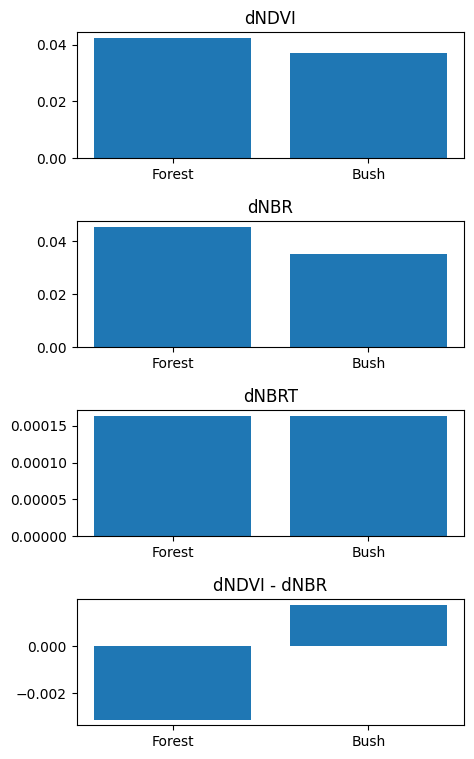

In [30]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5,9))

x1 = ['Forest', 'Bush',]
y1 = [dNDVI_forest, dNDVI_bush ]

x2 = ['Forest', 'Bush']
y2 = [dNBR_forest, dNBR_bush]

x3 = ['Forest', 'Bush']
y3 = [dNBRT_forest, dNBRT_bush]

x4 = ['Forest', 'Bush',]
y4 = [dNDVI_dNBR_forest, dNDVI_dNBR_bush ]

ax1.bar(x1, y1)
ax1.set_title("dNDVI")

ax2.bar(x2, y2)
ax2.set_title("dNBR");

ax3.bar(x3, y3)
ax3.set_title("dNBRT");

ax4.bar(x4, y4)
ax4.set_title("dNDVI - dNBR");

plt.subplots_adjust(hspace=0.5)